<a href="https://colab.research.google.com/github/trinade96/Fortiate_Project/blob/master/Smart_Rules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Smart_Rules**

##### In this notebook, we will be looking at some clustering techniques that are not necessarily for identifying fraud vs. not fraud but for identifying the behaviour of such fraud cases which might include not frauds in the same cluster.
Look at following link for better understanding of decision trees <br>
https://www.displayr.com/how-is-splitting-decided-for-decision-trees/ 

##### **Packages Used**

In [0]:
import numpy as np
import pandas as pd
from numpy import log2 as log
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import graphviz
import pprint
from pandas.api.types import is_float_dtype

##### **Reading the data**

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
data = pd.read_excel('/gdrive/My Drive/Random-Forest-Rules-Final-Rearranged-mindmap.xlsx')
data.head()

,TRANSACTION_CURRENCY,PD4,PD11,PROC_CODE_12,PD8,MCC,POS_ENTRY_MODE,SERVICE_CODE,BILLING_AMOUNT,TRANSACTION_LOCAL_DATE,TRANSMISSION_DATE_TIME,RESPONSE_DATE_TIME,PAN,VALID_FROM,EXPIRY_DATE,PROC_CODE_34,PROC_CODE_56,PD1,PD2,PD3,PD5,PD6,PD7,PD9,PD10,PD12,TRANSACTION_AMOUNT,BILLING_CURRENCY,CONVERSION_RATE_DATE,SETTLEMENT_AMOUNT,SETTLEMENT_CURRENCY,SETTLEMENT_DATE,ACQUIRING_COUNTRY_CODE,CARD_ACCEPTOR_TERM_ID,CARD_ACCEPTOR_ID,CARD_ACC_NAME_ADDRESS,AUTHORIZATION_CODE,DECISION,TARGET,C_100,C_40,C_20,ECOM_INFO,E_COM_INDICATOR
0,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,147.84,21-MAR-18 11.33.24,21-MAR-18 11.33.24,21-MAR-18 11.33.24,A1586941252148110,21-AUG-17 17.10.11,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,147.84,CURR356,000,145.22,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,800204,RESULT000,0,AMI,ACS,T0784,AXASK05AEVV,ECI05
1,CURR356,ATC9,TOC1,TC00,TVI0,MCC4814,NNN,UNK,399.00,21-MAR-18 11.34.15,21-MAR-18 11.34.15,21-MAR-18 11.34.15,A1586941241334010,06-APR-16 20.19.15,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,399.00,CURR356,000,391.94,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9822047692,PAYTM RETAIL -PG-ONLINE \\NOIDA\201301\,300255,RESULT000,0,AMI,ACS,T0797,AXASK05AEVV,ECI05
2,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,247.20,21-MAR-18 11.36.47,21-MAR-18 11.36.47,21-MAR-18 11.36.48,A1586941049519010,03-APR-18 14.19.03,01-APR-23 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,247.20,CURR356,000,242.82,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,700408,RESULT000,0,AMI,ACS,T0537,AXASK05AEVV,ECI05
3,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,359.00,21-MAR-18 11.39.44,21-MAR-18 11.39.44,21-MAR-18 11.39.44,A1586941050671000,20-APR-18 19.43.48,01-APR-23 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,359.00,CURR356,000,352.65,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,700585,RESULT000,0,AMI,ACS,T0796,AXASK05AEVV,ECI05
4,CURR356,ATC9,TOC1,TC00,TVI0,MCC5999,NNN,UNK,188.00,21-MAR-18 11.43.08,21-MAR-18 11.43.08,21-MAR-18 11.43.08,A1586941257961010,30-APR-16 20.49.02,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,188.00,CURR356,000,183.81,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9820524155,PAYTM.COM WALLET PG \\NOIDA\201310\\,400788,RESULT000,0,AMI,ACS,T0784,AXASK05AEVV,ECI05


In [4]:
data.shape

(105271, 44)

In [5]:
#This data has NaNs as we saw while using for DST-16, so we will remove such rows and use the rest in Decision Trees 
#Decision Trees cannot handle NaNs in data

data_dt = data.dropna(axis=0)
data_dt.shape

(22256, 44)

##### **Printing partitions done using sklearn using one of the datasets inbuilt in sklearn**

In [0]:
#Iris is a dataset on flower characteristics for 3 different varieties of the same flower
#Here we are trying to classify as the correct variety of flower given the characteristics
#Decision trees are a supervised learning technique, therefore they need labelled data to learn and classify unknown data points later on
X, y = load_iris(return_X_y=True)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

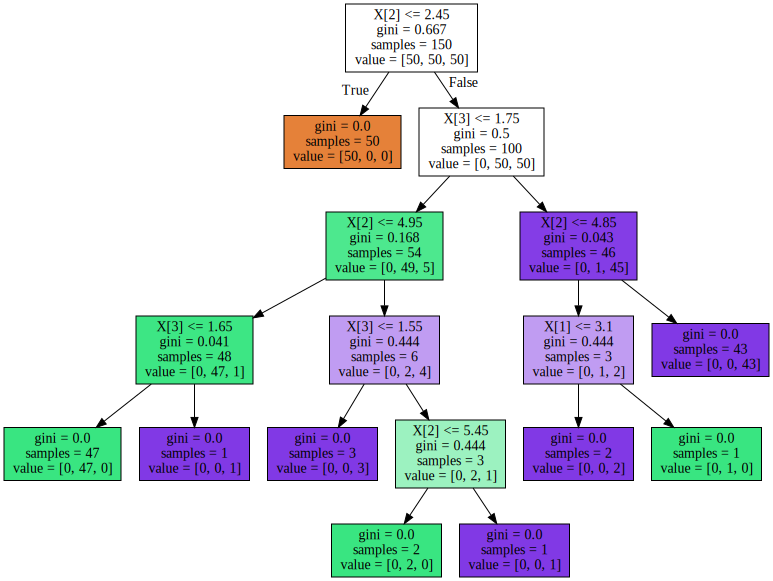

In [7]:
dot_data = tree.export_graphviz(clf, out_file=None,filled=True) 
graph = graphviz.Source(dot_data) 
graph

https://stackoverflow.com/questions/47503575/what-do-the-values-that-graphviz-renders-inside-each-node-of-a-decision-tree-m <br>
Look at this link for explanation of the values shown here, also instead of probabilities the value in each node shows the number of members of that node alloted to each of the 3 classes.

In [0]:
iris = load_iris()

In [9]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

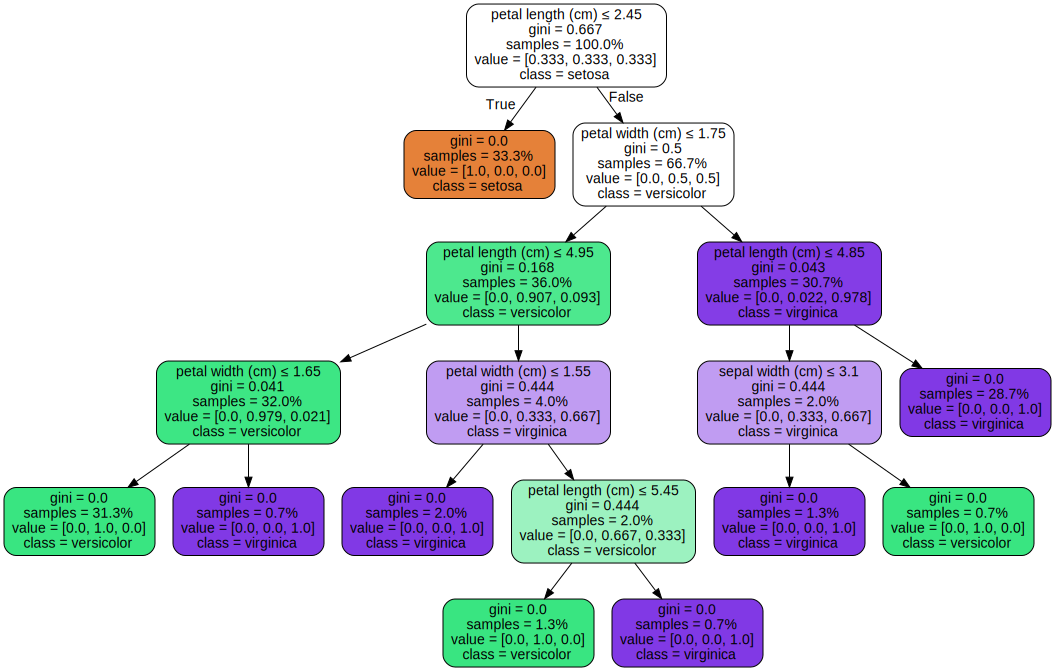

In [10]:
dot_data = tree.export_graphviz(clf, out_file=None, 
...                      feature_names=iris.feature_names,  
...                      class_names=iris.target_names,  
...                      filled=True, rounded=True,  
...                      special_characters=True,proportion=True)  
graph = graphviz.Source(dot_data)  
graph 

##### **Printing Decision Surface** <br>
Might not be feasible for data in higher dimensions

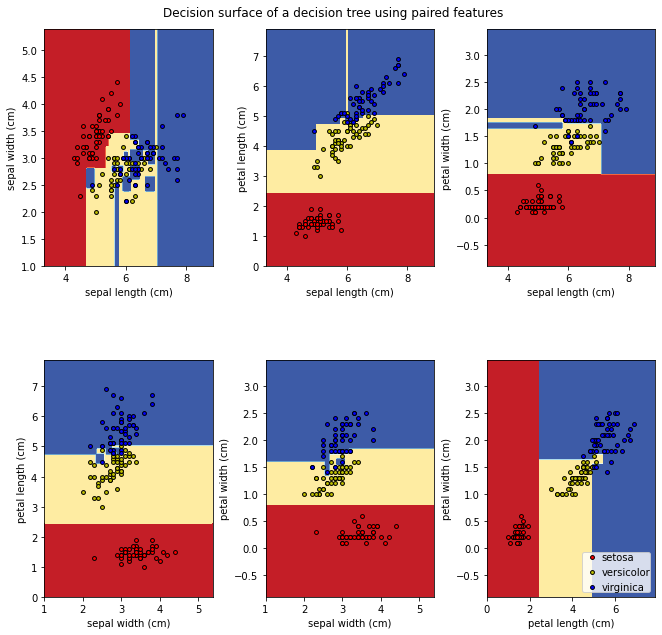

In [11]:
# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.25, w_pad=0.25, pad=1.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i], 
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(borderpad=0, handletextpad=0, loc = 'lower right')
plt.gcf().set_size_inches((10, 10))  
#plt.axis("tight")
plt.show()

##### These plots show us what the classification boundaries should be if we considered only two of the attributes at a time. For larger number of attributes, this would be difficult.

##### **Customized Decision Tree**
We will try to look at customized tree and try to see if we can dictate the first few partitions of the tree <br>
https://medium.com/@rakendd/decision-tree-from-scratch-9e23bcfb4928

In [0]:
eps = np.finfo(float).eps

In [0]:
dataset = {'Taste':['Salty','Spicy','Spicy','Spicy','Spicy','Sweet','Salty','Sweet','Spicy','Salty'],
       'Temperature':['Hot','Hot','Hot','Cold','Hot','Cold','Cold','Hot','Cold','Hot'],
       'Texture':['Soft','Soft','Hard','Hard','Hard','Soft','Soft','Soft','Soft','Hard'],
       'Eat':['No','No','Yes','No','Yes','Yes','No','Yes','Yes','Yes']}

In [14]:
df = pd.DataFrame(dataset,columns=['Taste','Temperature','Texture','Eat'])
df

,Taste,Temperature,Texture,Eat
0,Salty,Hot,Soft,No
1,Spicy,Hot,Soft,No
2,Spicy,Hot,Hard,Yes
3,Spicy,Cold,Hard,No
4,Spicy,Hot,Hard,Yes
5,Sweet,Cold,Soft,Yes
6,Salty,Cold,Soft,No
7,Sweet,Hot,Soft,Yes
8,Spicy,Cold,Soft,Yes
9,Salty,Hot,Hard,Yes


In [0]:
entropy_node = 0  #Initialize Entropy
values = df.Eat.unique()  #Unique objects - 'Yes', 'No'
for value in values:
    fraction = df.Eat.value_counts()[value]/len(df.Eat)  
    entropy_node += -fraction*np.log2(fraction)

\begin{equation}S=-\sum_{i=1}^{N} p_{i} \log _{2} p_{i}\end{equation} <br>
This is the formula for entropy we are using here, where pi is the proportion of members in that class

In [0]:
attribute = 'Taste'
target_variables = df.Eat.unique()  #This gives all 'Yes' and 'No'
variables = df[attribute].unique()    #This gives different features in that attribute (like 'Sweet')
entropy_attribute = 0
for variable in variables:
    entropy_each_feature = 0
    for target_variable in target_variables:
        num = len(df[attribute][df[attribute]==variable][df.Eat ==target_variable]) #numerator
        den = len(df[attribute][df[attribute]==variable])  #denominator
        fraction = num/(den+eps)  #pi
        entropy_each_feature += -fraction*log(fraction+eps) #This calculates entropy for one feature like 'Sweet'
    fraction2 = den/len(df)
    entropy_attribute += -fraction2*entropy_each_feature   #Sums up all the entropy ETaste

In [17]:
df[attribute][df[attribute]==variable][df.Eat ==target_variable]

5    Sweet
7    Sweet
Name: Taste, dtype: object

In [0]:
def find_entropy(df):
    Class = df.keys()[-1]   #To make the code generic, changing target variable class name
    entropy = 0
    values = df[Class].unique()
    for value in values:
        fraction = df[Class].value_counts()[value]/len(df[Class])
        entropy += -fraction*np.log2(fraction)
    return entropy
  
  
def find_entropy_attribute(df,attribute):
  Class = df.keys()[-1]   #To make the code generic, changing target variable class name
  target_variables = df[Class].unique()  #This gives all 'Yes' and 'No'
  variables = df[attribute].unique()    #This gives different features in that attribute (like 'Hot','Cold' in Temperature)
  entropy2 = 0
  for variable in variables:
      entropy = 0
      for target_variable in target_variables:
          num = len(df[attribute][df[attribute]==variable][df[Class] ==target_variable])
          den = len(df[attribute][df[attribute]==variable])
          fraction = num/(den+eps)
          entropy += -fraction*log(fraction+eps)
      fraction2 = den/len(df)
      entropy2 += -fraction2*entropy
  return abs(entropy2)


def find_winner(df):
    Entropy_att = []
    IG = []
    for key in df.keys()[:-1]:
    #Entropy_att.append(find_entropy_attribute(df,key))
        IG.append(find_entropy(df)-find_entropy_attribute(df,key))
    return df.keys()[:-1][np.argmax(IG)]
  
  
def get_subtable(df,node,value):
  return df[df[node] == value].reset_index(drop=True)


def buildTree(df,tree=None): 
    Class = df.keys()[-1]   #To make the code generic, changing target variable class name
    
    #Here we build our decision tree

    #Get attribute with maximum information gain
    node = find_winner(df)
    
    #Get distinct value of that attribute e.g Salary is node and Low,Med and High are values
    attValue = np.unique(df[node])
    
    #Create an empty dictionary to create tree    
    if tree is None:                    
        tree={}
        tree[node] = {}
    
   #We make loop to construct a tree by calling this function recursively. 
    #In this we check if the subset is pure and stops if it is pure. 

    for value in attValue:
        
        subtable = get_subtable(df,node,value)
        clValue,counts = np.unique(subtable['Eat'],return_counts=True)                        
        
        if len(counts)==1:#Checking purity of subset
            tree[node][value] = clValue[0]                                                    
        else:        
            tree[node][value] = buildTree(subtable) #Calling the function recursively 
                   
    return tree

In [19]:
tree_custom = buildTree(df)
pprint.pprint(tree_custom)

{'Taste': {'Salty': {'Texture': {'Hard': 'Yes', 'Soft': 'No'}},
           'Spicy': {'Temperature': {'Cold': {'Texture': {'Hard': 'No',
                                                          'Soft': 'Yes'}},
                                     'Hot': {'Texture': {'Hard': 'Yes',
                                                         'Soft': 'No'}}}},
           'Sweet': 'Yes'}}


##### **Prediction using this custom tree**

In [0]:
def predict(inst,tree):
    #This function is used to predict for any input variable 
    
    #Recursively we go through the tree that we built earlier

    for nodes in tree.keys():        
        
        value = inst[nodes]
        tree = tree[nodes][value]
        prediction = 0
            
        if type(tree) is dict:
            prediction = predict(inst, tree)
        else:
            prediction = tree
            break;                            
        
    return prediction

In [21]:
inst = df.iloc[6]
inst

Taste          Salty
Temperature     Cold
Texture         Soft
Eat               No
Name: 6, dtype: object

In [22]:
prediction = predict(inst,tree_custom)
prediction

'No'

In [0]:
inst2 = {'Taste':'Salty','Temperature':'Hot','Texture':'Hard'}
inst2 = pd.Series(inst2)

In [24]:
prediction2 = predict(inst2,tree_custom)
prediction2

'Yes'

##### **Modifying to our data(Hybrid Decision Tree)** <br> So we will be modifying the above code to accept some of our suggestions in the attributes at different levels

In [25]:
#This is the code that can work with datasets like the one we have
#Changing the target column to the end which is to be used for labeling
cols = data_dt.columns.tolist()
cols

['TRANSACTION_CURRENCY',
 'PD4',
 'PD11',
 'PROC_CODE_12',
 'PD8',
 'MCC',
 'POS_ENTRY_MODE',
 'SERVICE_CODE',
 'BILLING_AMOUNT',
 'TRANSACTION_LOCAL_DATE',
 'TRANSMISSION_DATE_TIME',
 'RESPONSE_DATE_TIME',
 'PAN',
 'VALID_FROM',
 'EXPIRY_DATE',
 'PROC_CODE_34',
 'PROC_CODE_56',
 'PD1',
 'PD2',
 'PD3',
 'PD5',
 'PD6',
 'PD7',
 'PD9',
 'PD10',
 'PD12',
 'TRANSACTION_AMOUNT',
 'BILLING_CURRENCY',
 'CONVERSION_RATE_DATE',
 'SETTLEMENT_AMOUNT',
 'SETTLEMENT_CURRENCY',
 'SETTLEMENT_DATE',
 'ACQUIRING_COUNTRY_CODE',
 'CARD_ACCEPTOR_TERM_ID',
 'CARD_ACCEPTOR_ID',
 'CARD_ACC_NAME_ADDRESS',
 'AUTHORIZATION_CODE',
 'DECISION',
 'TARGET',
 'C_100',
 'C_40',
 'C_20',
 'ECOM_INFO',
 'E_COM_INDICATOR']

In [26]:
cols = cols[:38]+cols[39:]+[cols[38]]
cols

['TRANSACTION_CURRENCY',
 'PD4',
 'PD11',
 'PROC_CODE_12',
 'PD8',
 'MCC',
 'POS_ENTRY_MODE',
 'SERVICE_CODE',
 'BILLING_AMOUNT',
 'TRANSACTION_LOCAL_DATE',
 'TRANSMISSION_DATE_TIME',
 'RESPONSE_DATE_TIME',
 'PAN',
 'VALID_FROM',
 'EXPIRY_DATE',
 'PROC_CODE_34',
 'PROC_CODE_56',
 'PD1',
 'PD2',
 'PD3',
 'PD5',
 'PD6',
 'PD7',
 'PD9',
 'PD10',
 'PD12',
 'TRANSACTION_AMOUNT',
 'BILLING_CURRENCY',
 'CONVERSION_RATE_DATE',
 'SETTLEMENT_AMOUNT',
 'SETTLEMENT_CURRENCY',
 'SETTLEMENT_DATE',
 'ACQUIRING_COUNTRY_CODE',
 'CARD_ACCEPTOR_TERM_ID',
 'CARD_ACCEPTOR_ID',
 'CARD_ACC_NAME_ADDRESS',
 'AUTHORIZATION_CODE',
 'DECISION',
 'C_100',
 'C_40',
 'C_20',
 'ECOM_INFO',
 'E_COM_INDICATOR',
 'TARGET']

In [27]:
data_dt = data_dt[cols]
data_dt.head()

,TRANSACTION_CURRENCY,PD4,PD11,PROC_CODE_12,PD8,MCC,POS_ENTRY_MODE,SERVICE_CODE,BILLING_AMOUNT,TRANSACTION_LOCAL_DATE,TRANSMISSION_DATE_TIME,RESPONSE_DATE_TIME,PAN,VALID_FROM,EXPIRY_DATE,PROC_CODE_34,PROC_CODE_56,PD1,PD2,PD3,PD5,PD6,PD7,PD9,PD10,PD12,TRANSACTION_AMOUNT,BILLING_CURRENCY,CONVERSION_RATE_DATE,SETTLEMENT_AMOUNT,SETTLEMENT_CURRENCY,SETTLEMENT_DATE,ACQUIRING_COUNTRY_CODE,CARD_ACCEPTOR_TERM_ID,CARD_ACCEPTOR_ID,CARD_ACC_NAME_ADDRESS,AUTHORIZATION_CODE,DECISION,C_100,C_40,C_20,ECOM_INFO,E_COM_INDICATOR,TARGET
0,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,147.84,21-MAR-18 11.33.24,21-MAR-18 11.33.24,21-MAR-18 11.33.24,A1586941252148110,21-AUG-17 17.10.11,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,147.84,CURR356,000,145.22,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,800204,RESULT000,AMI,ACS,T0784,AXASK05AEVV,ECI05,0
1,CURR356,ATC9,TOC1,TC00,TVI0,MCC4814,NNN,UNK,399.00,21-MAR-18 11.34.15,21-MAR-18 11.34.15,21-MAR-18 11.34.15,A1586941241334010,06-APR-16 20.19.15,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,399.00,CURR356,000,391.94,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9822047692,PAYTM RETAIL -PG-ONLINE \\NOIDA\201301\,300255,RESULT000,AMI,ACS,T0797,AXASK05AEVV,ECI05,0
2,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,247.20,21-MAR-18 11.36.47,21-MAR-18 11.36.47,21-MAR-18 11.36.48,A1586941049519010,03-APR-18 14.19.03,01-APR-23 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,247.20,CURR356,000,242.82,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,700408,RESULT000,AMI,ACS,T0537,AXASK05AEVV,ECI05,0
3,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,359.00,21-MAR-18 11.39.44,21-MAR-18 11.39.44,21-MAR-18 11.39.44,A1586941050671000,20-APR-18 19.43.48,01-APR-23 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,359.00,CURR356,000,352.65,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,700585,RESULT000,AMI,ACS,T0796,AXASK05AEVV,ECI05,0
4,CURR356,ATC9,TOC1,TC00,TVI0,MCC5999,NNN,UNK,188.00,21-MAR-18 11.43.08,21-MAR-18 11.43.08,21-MAR-18 11.43.08,A1586941257961010,30-APR-16 20.49.02,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,188.00,CURR356,000,183.81,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9820524155,PAYTM.COM WALLET PG \\NOIDA\201310\\,400788,RESULT000,AMI,ACS,T0784,AXASK05AEVV,ECI05,0


In [0]:
#We will only make some changes in the buildTree function to make our hybrid tree
#Here the argument determined_levels is a list with the names of the attributes as strings to be fixed at the levels in ascending order
def buildTree_hybrid(df,tree=None,determined_levels = []): 
    Class = df.keys()[-1]   #To make the code generic, changing target variable class name
    k = determined_levels
    #Here we build our decision tree
    if len(k) > 0:
      #Here the first attribute will be the cth column of the dataframe
      node = k[0]
    else:
      #Get attribute with maximum information gain
      node = find_winner(df)
    
    #Get distinct value of that attribute e.g Salary is node and Low,Med and High are values
    attValue = np.unique(df[node])
    
    #Create an empty dictionary to create tree    
    if tree is None:                    
        tree={}
        tree[node] = {}
    
   #We make loop to construct a tree by calling this function recursively. 
    #In this we check if the subset is pure and stops if it is pure. 

    for value in attValue:
        
        subtable = get_subtable(df,node,value)
        clValue,counts = np.unique(subtable[df.keys()[-1]],return_counts=True)                        
        
        if len(counts)==1:#Checking purity of subset
            tree[node][value] = clValue[0]                                                    
        else:
            if len(k) <= 1: 
              tree[node][value] = buildTree_hybrid(subtable)
            else:
              tree[node][value] = buildTree_hybrid(subtable,determined_levels=k[1:]) #Calling the function recursively 
                   
    return tree

###### Running this on the large dataset takes up too much time and hangs the system, so we will try on the smaller dataset df that consists of 'Temperature', 'Texture' and 'Taste' with the label column as 'Eat'. We will rearrange the columns to have 'Texture' at the beginning and then use it to be the first column always which was not the case if we see before.

In [29]:
df

,Taste,Temperature,Texture,Eat
0,Salty,Hot,Soft,No
1,Spicy,Hot,Soft,No
2,Spicy,Hot,Hard,Yes
3,Spicy,Cold,Hard,No
4,Spicy,Hot,Hard,Yes
5,Sweet,Cold,Soft,Yes
6,Salty,Cold,Soft,No
7,Sweet,Hot,Soft,Yes
8,Spicy,Cold,Soft,Yes
9,Salty,Hot,Hard,Yes


In [30]:
tree_custom2 = buildTree_hybrid(df,determined_levels=['Temperature','Texture'])
pprint.pprint(tree_custom2)

{'Temperature': {'Cold': {'Texture': {'Hard': 'No',
                                      'Soft': {'Taste': {'Salty': 'No',
                                                         'Spicy': 'Yes',
                                                         'Sweet': 'Yes'}}}},
                 'Hot': {'Texture': {'Hard': 'Yes',
                                     'Soft': {'Taste': {'Salty': 'No',
                                                        'Spicy': 'No',
                                                        'Sweet': 'Yes'}}}}}}


In [31]:
tree_custom3 = buildTree_hybrid(df,determined_levels=['Texture','Temperature','Taste'])
pprint.pprint(tree_custom3)

{'Texture': {'Hard': {'Temperature': {'Cold': 'No', 'Hot': 'Yes'}},
             'Soft': {'Temperature': {'Cold': {'Taste': {'Salty': 'No',
                                                         'Spicy': 'Yes',
                                                         'Sweet': 'Yes'}},
                                      'Hot': {'Taste': {'Salty': 'No',
                                                        'Spicy': 'No',
                                                        'Sweet': 'Yes'}}}}}}


##### So we have managed to fix the tree as we want, now we will just fix the first column as 'Temperature' and then let the whole tree fix itself

In [32]:
tree_custom4 = buildTree_hybrid(df,determined_levels=['Temperature'])
pprint.pprint(tree_custom4)

{'Temperature': {'Cold': {'Taste': {'Salty': 'No',
                                    'Spicy': {'Texture': {'Hard': 'No',
                                                          'Soft': 'Yes'}},
                                    'Sweet': 'Yes'}},
                 'Hot': {'Texture': {'Hard': 'Yes',
                                     'Soft': {'Taste': {'Salty': 'No',
                                                        'Spicy': 'No',
                                                        'Sweet': 'Yes'}}}}}}


##### Since this was not possible to try on our dataset, we will try and see if we can print the rules from standard decision tree in sklearn

##### **Using Label Encoder to convert the encoding on these columns of the dataset, also seperating out continuous and unique columns**

##### **Function to remove columns which are a list on distinct values for eg. the index**

In [0]:
def remove_index_like(df):
  df_new = df.copy()
  indices = []
  for i in df_new.columns:
    if len(df[i]) == len(set(df[i])):
      indices.append(i)
  df_new = df_new.drop(indices,1)
  return df_new

In [0]:
data_dt = remove_index_like(data_dt)

In [35]:
data_dt.shape

(22256, 44)

In [36]:
data_dt.head()

,TRANSACTION_CURRENCY,PD4,PD11,PROC_CODE_12,PD8,MCC,POS_ENTRY_MODE,SERVICE_CODE,BILLING_AMOUNT,TRANSACTION_LOCAL_DATE,TRANSMISSION_DATE_TIME,RESPONSE_DATE_TIME,PAN,VALID_FROM,EXPIRY_DATE,PROC_CODE_34,PROC_CODE_56,PD1,PD2,PD3,PD5,PD6,PD7,PD9,PD10,PD12,TRANSACTION_AMOUNT,BILLING_CURRENCY,CONVERSION_RATE_DATE,SETTLEMENT_AMOUNT,SETTLEMENT_CURRENCY,SETTLEMENT_DATE,ACQUIRING_COUNTRY_CODE,CARD_ACCEPTOR_TERM_ID,CARD_ACCEPTOR_ID,CARD_ACC_NAME_ADDRESS,AUTHORIZATION_CODE,DECISION,C_100,C_40,C_20,ECOM_INFO,E_COM_INDICATOR,TARGET
0,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,147.84,21-MAR-18 11.33.24,21-MAR-18 11.33.24,21-MAR-18 11.33.24,A1586941252148110,21-AUG-17 17.10.11,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,147.84,CURR356,000,145.22,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,800204,RESULT000,AMI,ACS,T0784,AXASK05AEVV,ECI05,0
1,CURR356,ATC9,TOC1,TC00,TVI0,MCC4814,NNN,UNK,399.00,21-MAR-18 11.34.15,21-MAR-18 11.34.15,21-MAR-18 11.34.15,A1586941241334010,06-APR-16 20.19.15,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,399.00,CURR356,000,391.94,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9822047692,PAYTM RETAIL -PG-ONLINE \\NOIDA\201301\,300255,RESULT000,AMI,ACS,T0797,AXASK05AEVV,ECI05,0
2,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,247.20,21-MAR-18 11.36.47,21-MAR-18 11.36.47,21-MAR-18 11.36.48,A1586941049519010,03-APR-18 14.19.03,01-APR-23 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,247.20,CURR356,000,242.82,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,700408,RESULT000,AMI,ACS,T0537,AXASK05AEVV,ECI05,0
3,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,359.00,21-MAR-18 11.39.44,21-MAR-18 11.39.44,21-MAR-18 11.39.44,A1586941050671000,20-APR-18 19.43.48,01-APR-23 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,359.00,CURR356,000,352.65,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,700585,RESULT000,AMI,ACS,T0796,AXASK05AEVV,ECI05,0
4,CURR356,ATC9,TOC1,TC00,TVI0,MCC5999,NNN,UNK,188.00,21-MAR-18 11.43.08,21-MAR-18 11.43.08,21-MAR-18 11.43.08,A1586941257961010,30-APR-16 20.49.02,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,188.00,CURR356,000,183.81,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9820524155,PAYTM.COM WALLET PG \\NOIDA\201310\\,400788,RESULT000,AMI,ACS,T0784,AXASK05AEVV,ECI05,0


##### So there are no index like columns here, so we can simply convert all of them via LabelEncoder to numeric encodings to be passed on to the decision tree, however we will first find out the float type columns and have them be as it is.


##### **Function to find float type columns in the dataframe**

In [0]:
#Function to find if a column is categorical or not and assign numerical encoding to it
def check_float(df):
  ## Keeping float data type columns as it is 
  float_cols = []
  new_df = pd.DataFrame()
  for col in df.columns:
    if(is_float_dtype(df[col])== True):
      new_df[col] = df[col]
      float_cols.append(col)
  return new_df, float_cols

In [38]:
float_df, float_cols = check_float(data_dt)
float_cols

['BILLING_AMOUNT', 'TRANSACTION_AMOUNT', 'SETTLEMENT_AMOUNT']

In [39]:
float_df.head()

,BILLING_AMOUNT,TRANSACTION_AMOUNT,SETTLEMENT_AMOUNT
0,147.84,147.84,145.22
1,399.00,399.00,391.94
2,247.20,247.20,242.82
3,359.00,359.00,352.65
4,188.00,188.00,183.81


In [40]:
data_dt2 = data_dt.drop(float_cols,1)
data_dt2.shape

(22256, 41)

In [41]:
data_dt_final = data_dt2.apply(preprocessing.LabelEncoder().fit_transform)
data_dt_final.head()

,TRANSACTION_CURRENCY,PD4,PD11,PROC_CODE_12,PD8,MCC,POS_ENTRY_MODE,SERVICE_CODE,TRANSACTION_LOCAL_DATE,TRANSMISSION_DATE_TIME,RESPONSE_DATE_TIME,PAN,VALID_FROM,EXPIRY_DATE,PROC_CODE_34,PROC_CODE_56,PD1,PD2,PD3,PD5,PD6,PD7,PD9,PD10,PD12,BILLING_CURRENCY,CONVERSION_RATE_DATE,SETTLEMENT_CURRENCY,SETTLEMENT_DATE,ACQUIRING_COUNTRY_CODE,CARD_ACCEPTOR_TERM_ID,CARD_ACCEPTOR_ID,CARD_ACC_NAME_ADDRESS,AUTHORIZATION_CODE,DECISION,C_100,C_40,C_20,ECOM_INFO,E_COM_INDICATOR,TARGET
0,2,1,1,0,0,104,0,0,0,0,0,536,8364,1,2,0,1,0,0,3,0,1,0,0,0,0,0,1,0,7,238,564,147,17162,0,0,0,465,21013,1,0
1,2,1,1,0,0,28,0,0,1,1,1,495,2249,1,2,0,1,0,0,3,0,1,0,0,0,0,0,1,0,7,238,526,657,4018,0,0,0,472,21013,1,0
2,2,1,1,0,0,104,0,0,2,2,2,294,861,4,2,0,1,0,0,3,0,1,0,0,0,0,0,1,0,7,238,564,147,14477,0,0,0,328,21013,1,0
3,2,1,1,0,0,104,0,0,3,3,3,317,7977,4,2,0,1,0,0,3,0,1,0,0,0,0,0,1,0,7,238,564,147,14481,0,0,0,471,21013,1,0
4,2,1,1,0,0,83,0,0,4,4,4,556,12776,1,2,0,1,0,0,3,0,1,0,0,0,0,0,1,0,7,238,506,664,6582,0,0,0,465,21013,1,0


In [42]:
#Reinstating the float columns as they are back into the data frame
for f in float_cols:
  data_dt_final[f] = data_dt[f]

data_dt_final.shape


(22256, 44)

In [43]:
data_dt_final.head()

,TRANSACTION_CURRENCY,PD4,PD11,PROC_CODE_12,PD8,MCC,POS_ENTRY_MODE,SERVICE_CODE,TRANSACTION_LOCAL_DATE,TRANSMISSION_DATE_TIME,RESPONSE_DATE_TIME,PAN,VALID_FROM,EXPIRY_DATE,PROC_CODE_34,PROC_CODE_56,PD1,PD2,PD3,PD5,PD6,PD7,PD9,PD10,PD12,BILLING_CURRENCY,CONVERSION_RATE_DATE,SETTLEMENT_CURRENCY,SETTLEMENT_DATE,ACQUIRING_COUNTRY_CODE,CARD_ACCEPTOR_TERM_ID,CARD_ACCEPTOR_ID,CARD_ACC_NAME_ADDRESS,AUTHORIZATION_CODE,DECISION,C_100,C_40,C_20,ECOM_INFO,E_COM_INDICATOR,TARGET,BILLING_AMOUNT,TRANSACTION_AMOUNT,SETTLEMENT_AMOUNT
0,2,1,1,0,0,104,0,0,0,0,0,536,8364,1,2,0,1,0,0,3,0,1,0,0,0,0,0,1,0,7,238,564,147,17162,0,0,0,465,21013,1,0,147.84,147.84,145.22
1,2,1,1,0,0,28,0,0,1,1,1,495,2249,1,2,0,1,0,0,3,0,1,0,0,0,0,0,1,0,7,238,526,657,4018,0,0,0,472,21013,1,0,399.00,399.00,391.94
2,2,1,1,0,0,104,0,0,2,2,2,294,861,4,2,0,1,0,0,3,0,1,0,0,0,0,0,1,0,7,238,564,147,14477,0,0,0,328,21013,1,0,247.20,247.20,242.82
3,2,1,1,0,0,104,0,0,3,3,3,317,7977,4,2,0,1,0,0,3,0,1,0,0,0,0,0,1,0,7,238,564,147,14481,0,0,0,471,21013,1,0,359.00,359.00,352.65
4,2,1,1,0,0,83,0,0,4,4,4,556,12776,1,2,0,1,0,0,3,0,1,0,0,0,0,0,1,0,7,238,506,664,6582,0,0,0,465,21013,1,0,188.00,188.00,183.81


In [44]:
X = np.array(data_dt_final.loc[:, data_dt_final.columns != 'TARGET'])
y = np.array(data_dt_final.loc[:,'TARGET'])
print(X.shape)
print(y.shape)

(22256, 43)
(22256,)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.1, random_state=42)

In [0]:
#There is an argument here called 'criterion' which is helpful 
#It can take values 'gini' and 'entropy', it will decide which method is used
clf = tree.DecisionTreeClassifier() 
clf = clf.fit(X_train, y_train)

In [47]:
xx = data_dt_final.loc[:, data_dt_final.columns != 'TARGET'].keys().tolist()
data_dt_final.loc[:, data_dt_final.columns != 'TARGET'].keys().tolist()


['TRANSACTION_CURRENCY',
 'PD4',
 'PD11',
 'PROC_CODE_12',
 'PD8',
 'MCC',
 'POS_ENTRY_MODE',
 'SERVICE_CODE',
 'TRANSACTION_LOCAL_DATE',
 'TRANSMISSION_DATE_TIME',
 'RESPONSE_DATE_TIME',
 'PAN',
 'VALID_FROM',
 'EXPIRY_DATE',
 'PROC_CODE_34',
 'PROC_CODE_56',
 'PD1',
 'PD2',
 'PD3',
 'PD5',
 'PD6',
 'PD7',
 'PD9',
 'PD10',
 'PD12',
 'BILLING_CURRENCY',
 'CONVERSION_RATE_DATE',
 'SETTLEMENT_CURRENCY',
 'SETTLEMENT_DATE',
 'ACQUIRING_COUNTRY_CODE',
 'CARD_ACCEPTOR_TERM_ID',
 'CARD_ACCEPTOR_ID',
 'CARD_ACC_NAME_ADDRESS',
 'AUTHORIZATION_CODE',
 'DECISION',
 'C_100',
 'C_40',
 'C_20',
 'ECOM_INFO',
 'E_COM_INDICATOR',
 'BILLING_AMOUNT',
 'TRANSACTION_AMOUNT',
 'SETTLEMENT_AMOUNT']

In [48]:
x = np.array(list(set(data_dt_final['TARGET'])))
x = list( map(str, x) )
x

['0', '1']

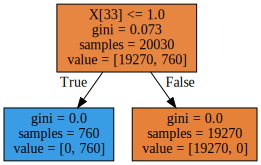

In [49]:
dot_data = tree.export_graphviz(clf, out_file=None,filled=True) 
graph = graphviz.Source(dot_data) 
graph

In [50]:
data_dt_final.keys()[33]

'AUTHORIZATION_CODE'

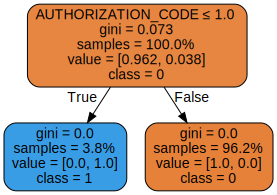

In [51]:
#Printing the decision rule that the decision tree follows for our data
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=xx, class_names=x,filled=True, rounded=True, special_characters=True,proportion=True)  
graph = graphviz.Source(dot_data)  
graph 

In [52]:
score = clf.score(X_test,y_test)
score

0.9995507637017071

##### But we should not get deceived by such good results because a majority of the values in the 'TARGET' column are "0" and so even if the decision tree learns to classify all of them as "0"s we would still see such an accuracy. It does not give a good idea about the classifier

In [53]:
y_prob = clf.predict_proba(X_test)
y_prob = y_prob[:,1]
y_prob
average_precision_score(y_test, y_prob)

0.9885057471264368

##### Precision-Recall Score is very good, but now we can still not be sure that our previous idea that our classifier is good was correct.

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.99')

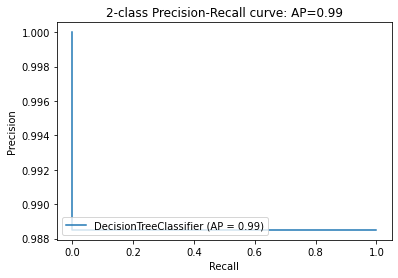

In [54]:
average_precision = average_precision_score(y_test, y_prob)
disp = plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

##### Here we become sure that our classifier was very poor indeed, because the curve for a good classifier should be above the diagonal and in the best case hugging the top right corner of the graph region which is not the case here.

##### **Applying above hybrid tree written manually on a section of our dataset**

In [55]:
#To reduce complexity we will cleverly pick those columns which have fewer distinct values
for col in data_dt_final.keys():
  if len(set(data_dt_final[col]))<=5:
    print(col,len(set(data_dt_final[col])))

PD4 2
PD11 2
PROC_CODE_12 2
PD8 1
POS_ENTRY_MODE 1
SERVICE_CODE 1
PROC_CODE_34 3
PROC_CODE_56 1
PD1 4
PD2 2
PD3 2
PD5 5
PD6 1
PD7 2
PD9 1
PD10 1
PD12 1
BILLING_CURRENCY 1
CONVERSION_RATE_DATE 1
SETTLEMENT_CURRENCY 2
SETTLEMENT_DATE 1
C_100 2
C_40 3
E_COM_INDICATOR 3
TARGET 2


In [67]:
#We will now setup a trial dataset to use on the hybrid decision tree code
data_trial = data_dt_final[['PD4','PD11','PROC_CODE_12','PROC_CODE_34','TARGET']]
#data_trial = data_trial.iloc[:100,:]
data_trial.shape

(22256, 5)

In [68]:
data_trial = data_trial.sample(n=10,random_state=42)
data_trial.shape

(10, 5)

In [0]:
import sys
sys.setrecursionlimit(150000)

In [70]:
tree_custom_data = buildTree_hybrid(data_trial,determined_levels=['PROC_CODE_12'])
pprint.pprint(tree_custom_data)

{'PROC_CODE_12': {0: {'PROC_CODE_34': {0: 0, 1: 1, 2: 0}}}}


In [72]:
tree_custom_data = buildTree_hybrid(data_trial,determined_levels=['PD11','PROC_CODE_12'])
pprint.pprint(tree_custom_data)

{'PD11': {0: {'PROC_CODE_12': {0: {'PROC_CODE_34': {0: 0, 1: 1}}}}, 1: 0}}


In [73]:
tree_custom_data = buildTree_hybrid(data_trial,determined_levels=['PD11','PD4','PROC_CODE_12'])
pprint.pprint(tree_custom_data)

{'PD11': {0: {'PD4': {0: {'PROC_CODE_12': {0: {'PROC_CODE_34': {0: 0,
                                                                1: 1}}}}}},
          1: 0}}


### **ROUGH WORK**


In [0]:
#Things to do:
#Try and print rules of custom tree in graph
#https://scikit-learn.org/stable/modules/tree.html
#https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree

In [0]:
np.array(list(set(data_dt_final['TARGET'])))

In [0]:
data_dt_final.loc[:,'TARGET']

In [0]:
data_dt.keys()[-1]

In [0]:
plt.figure(figsize=(20,20))
tree.plot_tree(clf, filled=True,fontsize = 10)